# Energy A.I. Hackathon 2021 Workflow - Team Anticline
## Prediction
#### Authors: Esmail Eltahan, Jeon Jonghyeon, Mehran Mehrabi, and Wen Pan, Hildebrand Department of Petroleum and Geosystems Engineering. 
#### The University of Texas at Austin, Austin, Texas USA 

<img src="anticline_official_logo.png" width=300 />



## Building ML Model 

Here, we build a ML model to predict the first year production.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import spatial
import seaborn as sns       #

## Load the data 



In [2]:
ai = np.load("2d_ai.npy")
sand_propotion = np.load("2d_sand_propotion.npy")
sandy_shale_propotion = np.load("2d_sandy_shale_propotion.npy")
shale_propotion = np.load("2d_shale_propotion.npy")
shaly_sand_propotion = np.load("2d_shaly_sand_propotion.npy")
top_depth = np.load("2d_top_depth.npy")

df_production = pd.read_csv('production_history.csv')
df_p = pd.read_csv('./imputed_data/df_p_{0:03d}.csv'.format(0))
df_n = pd.read_csv('./imputed_data/df_n_{0:03d}.csv'.format(0))
df_production.describe()

df_production.columns = ['Well_ID','Cumoil1', 'Cumoil2', 'Cumoil3', 'Cumwater1', 'Cumwater2', 'Cumwater3']

df_p.columns
df_p.columns = ['Well_ID','X','Y','Depth','Porosity','Perm','AI', 'Facies', 'Density','Comp_vel','E','Vs','G', 'layer', 'lith_id']
df_n.columns = ['Well_ID','X','Y','Depth','Porosity','Perm','AI','Facies', 'Density','Comp_vel','E','Vs','G','layer', 'lith_id']


In [3]:
df_p

,Well_ID,X,Y,Depth,Porosity,Perm,AI,Facies,Density,Comp_vel,E,Vs,G,layer,lith_id
0,Well_no_1,7325,7175,3052.80,0.133300,199.873650,6.981172e+06,Sandstone,2.280137,3106.544655,24.721555,1690.417133,7.304717,0,3
1,Well_no_1,7325,7175,3053.30,0.138650,199.873650,7.234749e+06,Sandstone,2.135061,4003.697087,23.360728,1573.847967,5.202120,1,3
2,Well_no_1,7325,7175,3053.80,0.146380,199.873650,7.157384e+06,Sandstone,1.991045,3462.569030,28.232152,1636.279139,5.580493,2,3
3,Well_no_1,7325,7175,3054.30,0.159798,199.873650,7.099159e+06,Sandstone,1.694242,3836.960702,29.220132,1613.043048,5.074763,3,3
4,Well_no_1,7325,7175,3054.80,0.149930,199.873650,7.158214e+06,Sandstone,1.664371,3919.585777,29.717209,1636.846284,5.277834,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,Well_no_73,7975,7525,3062.64,0.162890,200.747596,7.055226e+06,Sandstone,2.092585,3413.160157,22.650756,1433.648193,5.527209,15,3
1456,Well_no_73,7975,7525,3063.14,0.159090,187.820825,7.150563e+06,Sandstone,2.109057,3315.647993,22.067756,1665.711440,5.853935,16,3
1457,Well_no_73,7975,7525,3063.64,0.156920,187.820825,6.978004e+06,Sandstone,1.620103,3978.875885,34.903631,1627.187093,3.044917,17,3
1458,Well_no_73,7975,7525,3064.14,0.157370,187.820825,7.014957e+06,Sandstone,1.759469,4043.551621,28.898905,1711.886682,5.013303,18,3


## Calculate properties

Here we calculate some properties from the dataset that might (or might not) turn useful. 



In [4]:
from scipy.stats import hmean
woc = 3067.4
distance_to_woc = woc - top_depth
k = 1
for df in [df_p, df_n]:
    xy1 = np.array([df['X'].values, df['Y'].values]).T
    kdtree = spatial.cKDTree(xy1)
    size_arr = xy1.shape[0]
    mindist=np.zeros(size_arr)
    df['Log_perm'] = np.log(df['Perm'])

    for i in range(size_arr):
        mindist[i] = (kdtree.query(xy1[i], k=100)[0][np.nonzero(kdtree.query(xy1[i], k=100)[0])]).min()
    mindist
    print(mindist.shape)
    df["mindist"] = mindist
    df["log_mindist"] = np.log(mindist)
    df["Top_depth"] = top_depth[df['X']//50, df['Y']//50]
    print(df_p.groupby("Well_ID"))
    df["interval"] = df.groupby("Well_ID")["Depth"].diff(1)
    df.loc[np.isnan(df["interval"]),"interval"] = df["Depth"] - df["Top_depth"]
    df["distance to woc"] =  woc - df["Depth"]
    unique_list = df["Well_ID"].unique()
    
    for well in unique_list:
        df.loc[df["Well_ID"] == well, "Avg_perm"] =(df.loc[(df["Well_ID"] == well) & (~ (np.isnan(df["Perm"]))), "Perm"]).mean()
        df.loc[df["Well_ID"] == well, "thickness"] = df.loc[df["Well_ID"] == well, "Depth"].max() - df.loc[df["Well_ID"] == well, "Depth"].min()
        df.loc[df["Well_ID"] == well, "bottom to woc"] =  woc - df.loc[df["Well_ID"] == well, "Depth"].max() 
        df.loc[df["Well_ID"] == well, "sand prp."] = df.loc[(df["Well_ID"] == well) & (df["Facies"] == "Sandstone")].shape[0]\
        /df.loc[(df["Well_ID"] == well)].shape[0]
        df.loc[df["Well_ID"] == well, "sandshaly prp."] = \
        df.loc[(df["Well_ID"] == well) & ((df["Facies"] == "Sandstone")|(df["Facies"] == "Shaly sandstone")) ].shape[0]\
        /df.loc[(df["Well_ID"] == well)].shape[0]
        
    df["k/log_mindist"] = df["Avg_perm"] / df["log_mindist"]
    df["coeff"] = 0.000527 * np.power(df["mindist"], 2) * df['Porosity']
    df["mindist_squared"] = np.power(df["mindist"], 2)
    df.to_csv("{}_processed.csv".format(k), index=False)
    k+=1
df_production['prod_o1'] = df_production['Cumoil1']
df_production['prod_o2'] = df_production['Cumoil2'] - df_production['Cumoil1']
df_production['prod_o3'] = df_production['Cumoil3'] - df_production['Cumoil2']
df_production['prod_w1'] = df_production['Cumwater1']
df_production['prod_w2'] = df_production['Cumwater2'] - df_production['Cumwater1']
df_production['prod_w3'] = df_production['Cumwater3'] - df_production['Cumwater2']

df_production['oil12'] = (df_production['prod_o2']- df_production['prod_o1'])/ df_production['prod_o1']
df_production['oil23'] = (df_production['prod_o3']- df_production['prod_o2'])/ df_production['prod_o2']

df_production['water12'] = (df_production['prod_w2']- df_production['prod_w1'])/ df_production['prod_w1']
df_production['water23'] = (df_production['prod_w3']- df_production['prod_w2'])/ df_production['prod_w2']


df_production['wcut1'] = df_production['Cumwater1'] / (df_production['Cumoil1'] + df_production['Cumwater1'])
df_production['wcut2'] = (df_production['Cumwater2'] - df_production['Cumwater1']) / (df_production['Cumoil2'] - df_production['Cumoil1'] + df_production['Cumwater2'] - df_production['Cumwater1'])
df_production['wcut3'] = (df_production['Cumwater3'] - df_production['Cumwater2'])/ (df_production['Cumoil3'] - df_production['Cumoil2'] + df_production['Cumwater3'] - df_production['Cumwater2'])

df_production['wcutincrease1'] = (df_production['wcut2']- df_production['wcut1'])/ (df_production['wcut1'])
df_production['wcutincrease2'] = (df_production['wcut3']- df_production['wcut2']) / (df_production['wcut2'])

df_production['total1'] = df_production['Cumwater1'] + df_production['Cumoil1']
df_production['total2'] = df_production['Cumwater2'] + df_production['Cumoil2']
df_production['total3'] = df_production['Cumwater3'] + df_production['Cumoil3']
# print( df_p.head(25))
df_producers_average = df_p.groupby(["Well_ID"], sort=False, as_index=False).mean()
df_nonproducers_average = df_n.groupby(["Well_ID"], sort=False, as_index=False).mean()
print(df_producers_average.head())
df_producers_average.reset_index(drop=True, inplace=True)
df_production.reset_index(drop=True, inplace=True)
df_merged = pd.concat([df_producers_average, df_production.iloc[:,1:]], axis=1)
df_merged.describe().T

(1460,)
(200,)
     Well_ID       X       Y    Depth  Porosity        Perm            AI  \
0  Well_no_1  7325.0  7175.0  3057.55  0.136063  163.838508  7.218588e+06   
1  Well_no_2  4225.0  3525.0  3052.54  0.129081  130.489441  7.313975e+06   
2  Well_no_3  7725.0  8275.0  3060.67  0.121242   72.512814  7.366260e+06   
3  Well_no_4  4425.0  6475.0  3051.61  0.141104  152.869748  7.275353e+06   
4  Well_no_5  2125.0  1225.0  3060.45  0.129506   81.170991  7.341486e+06   

    Density     Comp_vel          E  ...  interval  distance to woc  \
0  2.149767  3375.797050  25.810921  ...  0.473459             9.85   
1  2.131232  3539.327750  25.635220  ...  0.502878            14.86   
2  1.900741  3865.620500  28.351062  ...  0.458481             6.73   
3  1.977436  3702.560227  27.348244  ...  0.452856            15.79   
4  1.934642  3770.355523  28.129156  ...  0.435151             6.95   

     Avg_perm  thickness  bottom to woc  sand prp.  sandshaly prp.  \
0  163.838508        9.5 

,count,mean,std,min,25%,50%,75%,max
X,73.0,4.188699e+03,1783.143687,1.175000e+03,2.925000e+03,3.875000e+03,5.325000e+03,7.975000e+03
Y,73.0,5.770890e+03,2405.487844,7.750000e+02,3.825000e+03,6.125000e+03,7.625000e+03,9.775000e+03
Depth,73.0,3.055811e+03,3.282321,3.050370e+03,3.052790e+03,3.055810e+03,3.058310e+03,3.061550e+03
Porosity,73.0,1.285274e-01,0.011175,1.043500e-01,1.207911e-01,1.282753e-01,1.360628e-01,1.585898e-01
Perm,73.0,1.121833e+02,38.977173,4.371044e+01,8.608601e+01,1.046231e+02,1.338992e+02,2.240556e+02
AI,73.0,7.321999e+06,95919.249953,7.068685e+06,7.278630e+06,7.332724e+06,7.379287e+06,7.495054e+06
Density,73.0,2.042053e+00,0.143202,1.788905e+00,1.913598e+00,2.035292e+00,2.173341e+00,2.296214e+00
Comp_vel,73.0,3.694949e+03,269.171983,3.228883e+03,3.458389e+03,3.688454e+03,3.905169e+03,4.328387e+03
E,73.0,2.725519e+01,2.054536,2.385585e+01,2.553401e+01,2.682352e+01,2.887998e+01,3.137521e+01
Vs,73.0,1.676053e+03,19.679818,1.636044e+03,1.659222e+03,1.675781e+03,1.688161e+03,1.721952e+03


In [10]:
df_p

,Well_ID,X,Y,Depth,Porosity,Perm,AI,Facies,Density,Comp_vel,...,interval,distance to woc,Avg_perm,thickness,bottom to woc,sand prp.,sandshaly prp.,k/log_mindist,coeff,mindist_squared
0,Well_no_1,7325,7175,3052.80,0.133300,199.873650,6.981172e+06,Sandstone,2.280137,3106.544655,...,-0.030824,14.60,163.838508,9.5,5.10,0.75,0.85,30.746837,2.985587,42500.0
1,Well_no_1,7325,7175,3053.30,0.138650,199.873650,7.234749e+06,Sandstone,2.135061,4003.697087,...,0.500000,14.10,163.838508,9.5,5.10,0.75,0.85,30.746837,3.105413,42500.0
2,Well_no_1,7325,7175,3053.80,0.146380,199.873650,7.157384e+06,Sandstone,1.991045,3462.569030,...,0.500000,13.60,163.838508,9.5,5.10,0.75,0.85,30.746837,3.278546,42500.0
3,Well_no_1,7325,7175,3054.30,0.159798,199.873650,7.099159e+06,Sandstone,1.694242,3836.960702,...,0.500000,13.10,163.838508,9.5,5.10,0.75,0.85,30.746837,3.579086,42500.0
4,Well_no_1,7325,7175,3054.80,0.149930,199.873650,7.158214e+06,Sandstone,1.664371,3919.585777,...,0.500000,12.60,163.838508,9.5,5.10,0.75,0.85,30.746837,3.358057,42500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,Well_no_73,7975,7525,3062.64,0.162890,200.747596,7.055226e+06,Sandstone,2.092585,3413.160157,...,0.500000,4.76,101.067214,9.5,2.76,0.45,0.85,15.790790,31.118098,362500.0
1456,Well_no_73,7975,7525,3063.14,0.159090,187.820825,7.150563e+06,Sandstone,2.109057,3315.647993,...,0.500000,4.26,101.067214,9.5,2.76,0.45,0.85,15.790790,30.392156,362500.0
1457,Well_no_73,7975,7525,3063.64,0.156920,187.820825,6.978004e+06,Sandstone,1.620103,3978.875885,...,0.500000,3.76,101.067214,9.5,2.76,0.45,0.85,15.790790,29.977605,362500.0
1458,Well_no_73,7975,7525,3064.14,0.157370,187.820825,7.014957e+06,Sandstone,1.759469,4043.551621,...,0.500000,3.26,101.067214,9.5,2.76,0.45,0.85,15.790790,30.063571,362500.0


In [14]:
df_merged

,Well_ID,X,Y,Depth,Porosity,Perm,AI,Density,Comp_vel,E,...,water12,water23,wcut1,wcut2,wcut3,wcutincrease1,wcutincrease2,total1,total2,total3
0,Well_no_1,7325.0,7175.0,3057.55,0.136063,163.838508,7.218588e+06,2.149767,3375.797050,25.810921,...,0.498333,0.176383,0.523211,0.760734,0.842452,0.453970,0.107420,945.87,1920.60,2956.03
1,Well_no_2,4225.0,3525.0,3052.54,0.129081,130.489441,7.313975e+06,2.131232,3539.327750,25.635220,...,0.848394,0.290015,0.276321,0.543637,0.680079,0.967411,0.250980,821.40,1593.11,2388.90
2,Well_no_3,7725.0,8275.0,3060.67,0.121242,72.512814,7.366260e+06,1.900741,3865.620500,28.351062,...,0.411629,0.180015,0.507369,0.707343,0.793900,0.394142,0.122369,774.92,1559.56,2384.50
3,Well_no_4,4425.0,6475.0,3051.61,0.141104,152.869748,7.275353e+06,1.977436,3702.560227,27.348244,...,1.089358,0.361707,0.241404,0.531196,0.698910,1.200443,0.315728,1049.07,2045.18,3076.10
4,Well_no_5,2125.0,1225.0,3060.45,0.129506,81.170991,7.341486e+06,1.934642,3770.355523,28.129156,...,0.266738,0.123858,0.668309,0.799340,0.859109,0.196063,0.074773,783.56,1613.42,2481.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,Well_no_69,3375.0,775.0,3059.64,0.123919,86.086008,7.400189e+06,1.910332,4002.291514,29.393853,...,0.357542,0.153884,0.501858,0.670095,0.740061,0.335229,0.104412,1189.62,2399.12,3662.80
69,Well_no_70,3575.0,9775.0,3060.30,0.132842,123.298784,7.298873e+06,2.291798,3264.456957,24.821275,...,0.279437,0.126532,0.671018,0.811995,0.860189,0.210093,0.059354,1492.21,3069.93,4747.70
70,Well_no_71,6975.0,6525.0,3055.04,0.141619,165.335846,7.219434e+06,2.074350,3633.698256,26.666748,...,0.656326,0.255359,0.377398,0.646082,0.763758,0.711940,0.182137,826.82,1626.78,2476.29
71,Well_no_72,3825.0,2625.0,3055.11,0.112624,58.172831,7.455476e+06,1.955076,3901.345177,29.101971,...,0.712473,0.262356,0.320793,0.579376,0.711907,0.806074,0.228748,476.60,928.50,1392.76


## Compute pressure drop

Below we define two functions to calculate estimates for the pressure drop. The first one `compute_dp_map` computes the pressure drop all over the grid. The second one `compute_dp_map` computes the pressure drop at an individual well location. The pessure drop at any location is the superposition of the drop caused by adjacent wells. i.e., 

$$ \Delta P = \sum_{i}^{N} \Delta P_i$$
where, 
$$ \Delta P_i = \frac{-70.6qB\mu}{kh} Ei \left(\frac{-984 \phi \mu c_t r_i ^2}{kt}\right) $$

for all wells $i\in[N]$. $r_i$ is the Euclidean distance between a contributing well $i$ and the point of interest. 

Similarly, the pressure drop at a  well location can be estimated in a similar manner and adding a term that accounts for the drop due to its own depletion: 
$$ \Delta P_A = \Delta P_A + \sum_{i}^{N} \Delta P_i$$
where, 

$$ \Delta P_A = \frac{-70.6qB\mu}{kh} \ln \left(\frac{-1688 \phi \mu c_t r_w ^2}{kt}\right) $$
$$ \Delta P_i = \frac{-70.6q_iB\mu}{kh} Ei \left(\frac{-984 \phi \mu c_t r_{i-A} ^2}{kt}\right) $$

In [15]:

from scipy.spatial.distance import cdist
from scipy.special import expi

def compute_dp_map(grid, wells, poros, perms, prods_oil, prods_water, t):
    beta_o = 1.5
    beta_w = 1.05
    mu_o = 20.
    mu_w = 1
    h = 10 * 3.28084
    c_t = 1e-6
    distances = cdist(grid, wells)
    distances[np.where(distances< 10)] = 10
    n = grid.shape[0]
    delta_p = np.zeros(n)
    
    delta_p += np.sum(-70.6 * prods_oil *beta_o * mu_o / (perms * h) * expi(-984 * 10.7639 * poros * mu_o * c_t * distances **2 / (perms * t)), axis =1)
    delta_p += np.sum(-70.6 * prods_water *beta_w * mu_w / (perms * h) * expi(-984 * 10.7639 * poros * mu_w * c_t * distances **2 / (perms * t)), axis =1)

    return delta_p

def compute_dp_well(well, wells,por, poros, perm,  perms, prod_oil, prods_oil, prod_water, prods_water, t):
    rw = 0.2
    beta_o = 1.5
    beta_w = 1.05
    mu_o = 20.
    mu_w = 1
    h = 10 * 3.28084
    c_t = 1e-6
    distances = cdist(well, wells)
#     distances[np.where(distances< 10)] = 10
#     n = well.shape[0]
#     delta_p = np.zeros(n)
    delta_p = -70.6 * prod_oil *beta_o * mu_o / (perm * h) * np.log(1688 * mu_o *por *c_t * rw **2 / (perm * t))
    delta_p += -70.6 * prod_water *beta_w * mu_w / (perm * h) * np.log(1688 * mu_w *por *c_t * rw **2 / (perm * t))
#     print(delta_p.shape)
#     print(perms.shape)
#     print(distances.shape)
#     print(distances)
    for i in range(len(wells)):
        delta_p += -70.6 * prods_oil[i] *beta_o * mu_o / (perms[i] * h) * expi(-984 * 10.7639 * poros[i] * mu_o * c_t * distances.T[i] **2 / (perms[i] * t))
        delta_p += -70.6 * prods_water[i] *beta_w * mu_w / (perms[i] * h) * expi(-984 * 10.7639 * poros[i] * mu_w * c_t * distances.T[i] **2 / (perms[i] * t))
    return delta_p



In [16]:
from scipy.spatial.distance import cdist
x = np.linspace(25,10000 -25, 200)
y = x
X, Y = np.meshgrid(x, y, indexing='ij' )
xy = np.array([df_producers_average['X'].values, df_producers_average['Y'].values]).T
prods_oil1 = df_merged['Cumoil1'].values
prods_oil2 = df_merged['Cumoil2'].values - df_merged['Cumoil1'].values
prods_oil3 = df_merged['Cumoil3'].values - df_merged['Cumoil2'].values

prods_water1 = df_merged['Cumwater1'].values
prods_water2 = df_merged['Cumwater2'].values - df_merged['Cumwater1'].values
prods_water3 = df_merged['Cumwater3'].values - df_merged['Cumwater2'].values

poros = df_merged['Porosity'].values
perms = df_merged['Avg_perm'].values
# print(prods.shape)
# X, Y = np.meshgrid[x, y]
positions = np.array((X,Y)).T

# print(positions.reshape([40000, 2]).shape)
positions=positions.reshape([40000, 2])
# print(positions)
# positions = np.squeeze(positions, axis = 1)

distances = cdist(positions, xy)
distances.shape
n = positions.shape[0]
delta_p = np.zeros(n)
# delta_p = np.sum(distances*prods1, axis =1)
# print(distances.shape)
# print(delta_p.shape)
# print(delta_p)

# print(sum(distances[0]*prods))
# print(np.amin(distances))

# kdtree = spatial.cKDTree(xy1)
# size_arr = xy1.shape[0]
# mindist=np.zeros(size_arr)

avg_por = 0.128
avg_perm = 80.
# dp_1 = compute_dp_map(positions, xy, poros, perms, prods_oil1/365, prods_water1/365,1*365*24)
# dp_2 = compute_dp_map(positions, xy, poros, perms, prods_oil2/365, prods_water2/365, 1*365*24) + dp_1
# dp_3 = compute_dp_map(positions, xy, poros, perms, prods_oil3/365, prods_water3/365, 1*365*24) + dp_2

dp_1 = compute_dp_map(positions, xy, avg_por, avg_perm, prods_oil1/365, prods_water1/365,1*365*24)
dp_2 = compute_dp_map(positions, xy, avg_por, avg_perm, prods_oil2/365, prods_water2/365, 1*365*24) + dp_1
dp_3 = compute_dp_map(positions, xy, avg_por, avg_perm, prods_oil3/365, prods_water3/365, 1*365*24) + dp_2

from scipy import stats
# print(np.where(dp_1 >100))
stats.describe(dp_1)
# print(dp_1.shape)
dp_1 = dp_1.reshape([200,200])
dp_2 = dp_2.reshape([200,200])
dp_3 = dp_3.reshape([200,200])


np.save("./engineered_maps/dp_1", dp_1)
np.save("./engineered_maps/dp_2", dp_2)
np.save("./engineered_maps/dp_3", dp_3)
# df_merged["dp_1"] = dp_1[df_merged['X']//50, df_merged['Y']//50]
# df_merged["dp_2"] = dp_2[df_merged['X']//50, df_merged['Y']//50]
# df_merged["dp_3"] = dp_3[df_merged['X']//50, df_merged['Y']//50]

for well in df_merged["Well_ID"].unique():
        well_coords = np.array([df_merged.loc[df_merged["Well_ID"] == well, "X"].values, df_merged.loc[df_merged["Well_ID"] == well, "Y"].values]).T
        wells_coords = np.array([df_merged.loc[df_merged["Well_ID"] != well, "X"].values, df_merged.loc[df_merged["Well_ID"] != well, "Y"].values]).T
        
        prod_oil_1 = df_merged.loc[df_merged["Well_ID"] == well, "Cumoil1"].values
        prod_oil_2 = df_merged.loc[df_merged["Well_ID"] == well, "Cumoil2"].values - prod_oil_1
        prod_oil_3 = df_merged.loc[df_merged["Well_ID"] == well, "Cumoil3"].values - prod_oil_2
        
        prod_water_1 = df_merged.loc[df_merged["Well_ID"] == well, "Cumwater1"].values
        prod_water_2 = df_merged.loc[df_merged["Well_ID"] == well, "Cumwater1"].values - prod_water_1
        prod_water_3 = df_merged.loc[df_merged["Well_ID"] == well, "Cumwater1"].values - prod_water_2
        
        prods_oil_1 = df_merged.loc[df_merged["Well_ID"] != well, "Cumoil1"].values
        prods_oil_2 = df_merged.loc[df_merged["Well_ID"] != well, "Cumoil2"].values - prods_oil_1
        prods_oil_3 = df_merged.loc[df_merged["Well_ID"] != well, "Cumoil3"].values - prods_oil_2
        
        prods_water_1 = df_merged.loc[df_merged["Well_ID"] != well, "Cumwater1"].values
        prods_water_2 = df_merged.loc[df_merged["Well_ID"] != well, "Cumwater1"].values - prods_water_1
        prods_water_3 = df_merged.loc[df_merged["Well_ID"] != well, "Cumwater1"].values - prods_water_2
        
        por = df_merged.loc[df_merged["Well_ID"] == well, "Porosity"].values
        perm = df_merged.loc[df_merged["Well_ID"] == well, "Avg_perm"].values
        poros = df_merged.loc[df_merged["Well_ID"] != well, "Porosity"].values
        perms = df_merged.loc[df_merged["Well_ID"] != well, "Avg_perm"].values
        
#         df_merged.loc[df_merged["Well_ID"] == well, "dp_1"] = compute_dp_well(well_coords, wells_coords, por, poros, perm, perms, prod_oil_1/365,prods_oil_1/365, prod_water_1/365,prods_water_1/365,1*365*24)
#         df_merged.loc[df_merged["Well_ID"] == well, "dp_2"] = compute_dp_well(well_coords, wells_coords, por, poros, perm, perms, prod_oil_1/365,prods_oil_1/365, prod_water_1/365,prods_water_1/365,1*365*24)
#         df_merged.loc[df_merged["Well_ID"] == well, "dp_3"] = compute_dp_well(well_coords, wells_coords, por, poros, perm, perms, prod_oil_1/365,prods_oil_1/365, prod_water_1/365,prods_water_1/365,1*365*24)
        avg_perms = np.ones_like(perms) * avg_perm
        avg_pors = np.ones_like(poros) * avg_por

        df_merged.loc[df_merged["Well_ID"] == well, "dp_1"] = compute_dp_well(well_coords, wells_coords, avg_por, avg_pors, avg_perm, avg_perms, prod_oil_1/365,prods_oil_1/365, prod_water_1/365,prods_water_1/365,1*365*24)
        df_merged.loc[df_merged["Well_ID"] == well, "dp_2"] = compute_dp_well(well_coords, wells_coords, avg_por, avg_pors, avg_perm, avg_perms, prod_oil_1/365,prods_oil_1/365, prod_water_1/365,prods_water_1/365,1*365*24)
        df_merged.loc[df_merged["Well_ID"] == well, "dp_3"] = compute_dp_well(well_coords, wells_coords, avg_por, avg_pors, avg_perm, avg_perms, prod_oil_1/365,prods_oil_1/365, prod_water_1/365,prods_water_1/365,1*365*24)

In [17]:
woc_rise_1 = np.load("./engineered_maps/woc_rise_1.npy")
woc_rise_2 = np.load("./engineered_maps/woc_rise_2.npy")
woc_rise_3 = np.load("./engineered_maps/woc_rise_3.npy")
print(woc_rise_1.mean())
woc_rise_1_squared = woc_rise_1 ** 2 * woc_rise_1.mean()/ (woc_rise_1 ** 2).mean()
woc_rise_2_squared = woc_rise_2 ** 2 * woc_rise_2.mean()/ (woc_rise_2 ** 2).mean()
woc_rise_3_squared = woc_rise_3 ** 2 * woc_rise_3.mean()/ (woc_rise_3 ** 2).mean()

df_merged["woc rise 0"] = 0
df_merged["woc rise 1"] = woc_rise_1[df_merged['X'].astype('int')//50, df_merged['Y'].astype('int')//50] 
df_merged["woc rise 2"] = woc_rise_2[df_merged['X'].astype('int')//50, df_merged['Y'].astype('int')//50] 
df_merged["woc rise 3"] = woc_rise_3[df_merged['X'].astype('int')//50, df_merged['Y'].astype('int')//50] 

df_merged["bottom to woc 1"] = df_merged["bottom to woc"] - woc_rise_1[df_merged['X'].astype('int')//50, df_merged['Y'].astype('int')//50] 
df_merged["bottom to woc 2"] = df_merged["bottom to woc"] - woc_rise_2[df_merged['X'].astype('int')//50, df_merged['Y'].astype('int')//50] 
df_merged["bottom to woc 3"] = df_merged["bottom to woc"] - woc_rise_3[df_merged['X'].astype('int')//50, df_merged['Y'].astype('int')//50] 

df_merged["bottom to woc 1s"] = df_merged["bottom to woc"] - woc_rise_1_squared[df_merged['X'].astype('int')//50, df_merged['Y'].astype('int')//50] 
df_merged["bottom to woc 2s"] = df_merged["bottom to woc"] - woc_rise_2_squared[df_merged['X'].astype('int')//50, df_merged['Y'].astype('int')//50] 
df_merged["bottom to woc 3s"] = df_merged["bottom to woc"] - woc_rise_3_squared[df_merged['X'].astype('int')//50, df_merged['Y'].astype('int')//50] 

0.8397517210024935


# PCA


In [37]:
df_merged.iloc[:,0:28].columns

Index(['Well_ID', 'X', 'Y', 'Depth', 'Porosity', 'Perm', 'AI', 'Density',
       'Comp_vel', 'E', 'Vs', 'G', 'layer', 'lith_id', 'Log_perm', 'mindist',
       'log_mindist', 'Top_depth', 'interval', 'distance to woc', 'Avg_perm',
       'thickness', 'bottom to woc', 'sand prp.', 'sandshaly prp.',
       'k/log_mindist', 'coeff', 'mindist_squared'],
      dtype='object')

In [41]:
df_merged.iloc[:,3:28].columns

Index(['Depth', 'Porosity', 'Perm', 'AI', 'Density', 'Comp_vel', 'E', 'Vs',
       'G', 'layer', 'lith_id', 'Log_perm', 'mindist', 'log_mindist',
       'Top_depth', 'interval', 'distance to woc', 'Avg_perm', 'thickness',
       'bottom to woc', 'sand prp.', 'sandshaly prp.', 'k/log_mindist',
       'coeff', 'mindist_squared'],
      dtype='object')

In [38]:
var_pca=df_merged.iloc[:,3:28].values

In [52]:
from sklearn.decomposition import PCA    
from sklearn.preprocessing import StandardScaler
var_pca_std = StandardScaler().fit_transform(var_pca)                     # standardize the data features to mean = 0, var = 1.0

In [50]:
pd.DataFrame(var_pca_std).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,73.0,2.103340e-14,1.00692,-1.669128,-0.926742,-0.000294,0.766633,1.760571
1,73.0,9.469214e-16,1.00692,-2.178545,-0.697093,-0.022714,0.678990,2.708808
2,73.0,-2.813579e-17,1.00692,-1.768900,-0.674187,-0.195306,0.561000,2.890064
3,73.0,-5.244283e-15,1.00692,-2.659182,-0.455269,0.112584,0.601387,1.816655
4,73.0,6.729777e-16,1.00692,-1.780000,-0.903228,-0.047541,0.923147,1.787121
5,73.0,-6.037788e-16,1.00692,-1.743462,-0.884926,-0.024296,0.786393,2.369569
6,73.0,-8.646052e-16,1.00692,-1.666007,-0.843544,-0.211562,0.796304,2.019204
7,73.0,1.368768e-16,1.00692,-2.047077,-0.861136,-0.013894,0.619530,2.348433
8,73.0,1.885858e-16,1.00692,-1.834521,-0.817397,-0.076018,0.783225,2.231612
9,73.0,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000


In [63]:
n_components = 24
pca = PCA(n_components=n_components)
pca.fit(var_pca_std)

PCA(n_components=24)

In [60]:
print(np.round(pca.components_,3))

[[-0.165  0.281  0.292 -0.281  0.215 -0.246 -0.265  0.01   0.167  0.
   0.292  0.277 -0.057 -0.08  -0.188  0.016  0.165  0.292  0.     0.165
   0.274  0.12   0.295 -0.005 -0.036]
 [-0.126  0.052  0.079 -0.018 -0.1    0.081  0.084  0.013 -0.105  0.
   0.003  0.06   0.469  0.447 -0.045 -0.201  0.126  0.079 -0.     0.126
   0.011  0.08  -0.003  0.467  0.46 ]]


In [64]:
print('Variance explained by PC1 and PC2 =', np.round(pca.explained_variance_ratio_,3))

Variance explained by PC1 and PC2 = [0.392 0.172 0.154 0.128 0.05  0.038 0.024 0.015 0.008 0.006 0.005 0.004
 0.002 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]


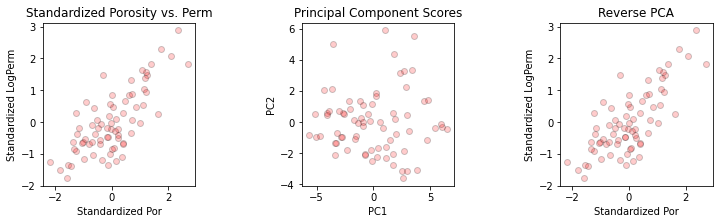

In [58]:
f, (ax101, ax102, ax103) = plt.subplots(1, 3,figsize=(12,3))
f.subplots_adjust(wspace=0.7)

ax101.scatter(var_pca_std[:,1],var_pca_std[:,2], s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, edgecolors="black")
ax101.set_title('Standardized Porosity vs. Perm'); ax101.set_xlabel('Standardized Por'); ax101.set_ylabel('Standardized LogPerm')

x_trans = pca.transform(var_pca_std)                                # calculate the principal component scores
ax102.scatter(x_trans[:,0],x_trans[:,1],s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, edgecolors="black")
ax102.set_title('Principal Component Scores'); ax102.set_xlabel('PC1'); ax102.set_ylabel('PC2')

x_reverse = pca.inverse_transform(x_trans)                        # reverse the principal component scores to standardized values
ax103.scatter(x_reverse[:,1],x_reverse[:,2],s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, edgecolors="black")
ax103.set_title('Reverse PCA'); ax103.set_xlabel('Standardized Por'); ax103.set_ylabel('Standardized LogPerm')
plt.show()

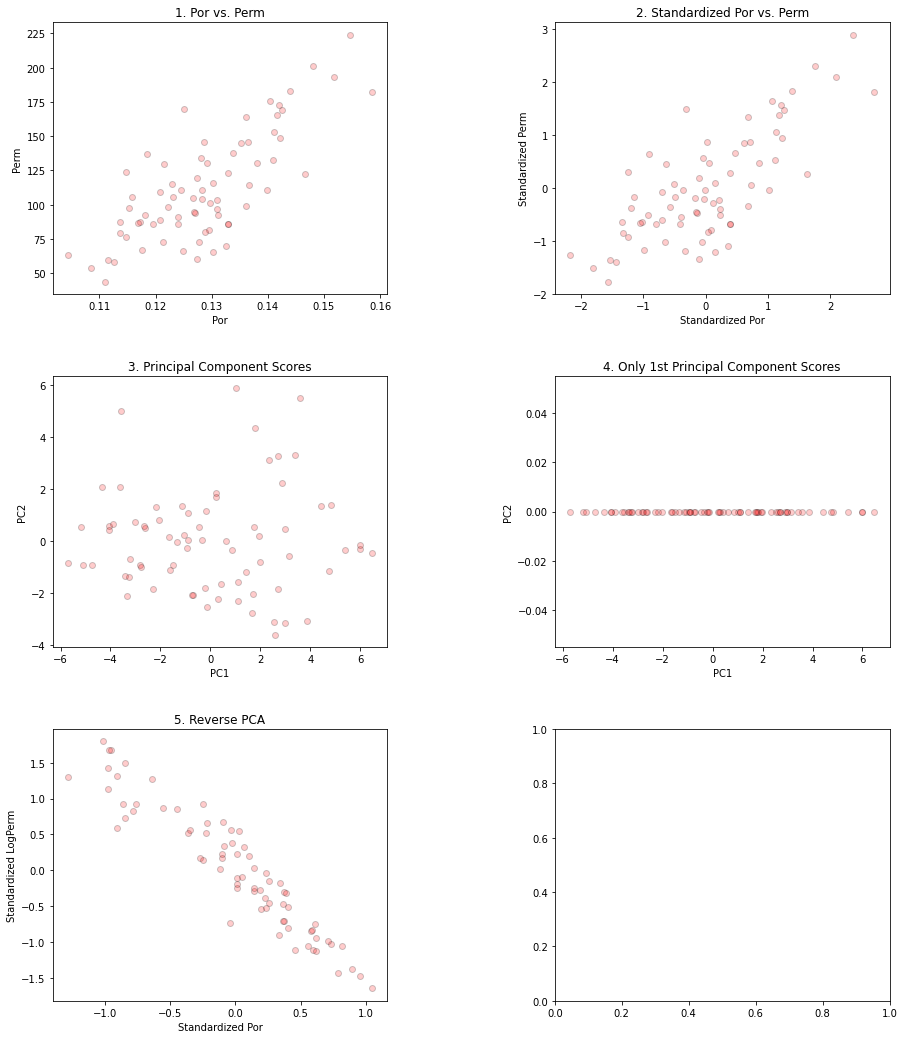

In [75]:
nComp = 1
f, ((ax201, ax202), (ax203, ax204), (ax205, ax206)) = plt.subplots(3, 2,figsize=(15,18))
f.subplots_adjust(wspace=0.5,hspace = 0.3)

ax201.scatter(df_merged.iloc[:,4],df_merged.iloc[:,5],s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, edgecolors="black")
ax201.set_title('1. Por vs. Perm'); ax201.set_xlabel('Por'); ax201.set_ylabel('Perm')

ax202.scatter(var_pca_std[:,1],var_pca_std[:,2], s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, edgecolors="black")
ax202.set_title('2. Standardized Por vs. Perm'); ax202.set_xlabel('Standardized Por'); ax202.set_ylabel('Standardized Perm')

n_components = 2                                          # build principal component model with 2 components
pca = PCA(n_components=n_components)
pca.fit(var_pca_std)

x_trans = pca.transform(var_pca_std)                                # calculate principal component scores
ax203.scatter(x_trans[:,0],x_trans[:,1],s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, edgecolors="black")
ax203.set_title('3. Principal Component Scores'); ax203.set_xlabel('PC1'); ax203.set_ylabel('PC2')

temp=x_trans[:,1]*0                                  # zero / remove the 2nd principal component 

ax204.scatter(x_trans[:,0],temp,s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, edgecolors="black")
ax204.set_title('4. Only 1st Principal Component Scores'); ax204.set_xlabel('PC1'); ax204.set_ylabel('PC2')

xhat = pca.inverse_transform(x_trans)                             # reverse the principal component scores to standardized values
ax205.scatter(xhat[:,0],xhat[:,1],s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, edgecolors="black")
ax205.set_title('5. Reverse PCA'); ax205.set_xlabel('Standardized Por'); ax205.set_ylabel('Standardized LogPerm')

plt.show()

Text(0, 0.5, 'explained_variance_ratio')

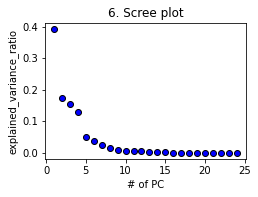

In [97]:
n_components = 24                                          # build principal component model with 2 components
pca = PCA(n_components=n_components)
pca.fit(var_pca_std)

evr={'explained_variance_ratio':np.round(pca.explained_variance_ratio_,3),'# of PC': np.arange(1,25,1)}
df_evr=pd.DataFrame(data=evr)
f, (ax16) = plt.subplots(1,1,figsize=(3.6,2.5))
f.subplots_adjust(wspace=0.7)
ax16.scatter(df_evr["# of PC"],df_evr["explained_variance_ratio"],s=None, c="blue", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=1, linewidths=1.0, edgecolors="black")
ax16.set_title('6. Scree plot'); ax16.set_xlabel('# of PC'); ax16.set_ylabel('explained_variance_ratio')

In [103]:
n_components = 4                                          # build principal component model with 2 components
pca = PCA(n_components=n_components)
pca.fit(var_pca_std)

x_trans = pca.transform(var_pca_std)           
xhat = pca.inverse_transform(x_trans)                             # reverse the principal component scores to standardized values

In [113]:
df_pca=pd.DataFrame(x_trans)

In [107]:
df_rev_pca_merged=pd.DataFrame(xhat)
df_rev_pca_merged

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.436530,1.390138,1.145787,-1.453181,0.649843,-0.839743,-0.964825,-0.358697,0.436405,-1.254169e-20,...,0.664216,-0.436530,1.145787,-3.702783e-42,-0.436530,1.366377,0.943847,1.397663,-1.471262,-1.613571
1,-1.037454,0.157752,0.357398,-0.316696,0.828147,-0.777791,-0.847548,0.219281,0.757538,-5.800626e-21,...,0.148904,1.037454,0.357398,4.377801e-41,1.037454,0.271691,-0.401430,0.665891,-1.727140,-1.754784
2,1.439992,-0.699194,-0.958012,0.693131,-0.698851,0.760797,0.817313,-0.264240,-0.558751,4.310529e-23,...,0.491182,-1.439992,-0.958012,-1.141728e-41,-1.439992,-0.651654,-0.092733,-0.885614,-0.477041,-0.387825
3,-1.159678,1.066543,1.218051,-1.002158,-0.395824,0.157074,0.035692,-0.143021,-0.561189,-2.729176e-20,...,-1.168581,1.159678,1.218051,-8.374423e-42,1.159678,0.766548,0.970965,1.085746,0.648679,0.522785
4,1.366575,-0.346947,-0.626587,0.363135,-0.968000,0.937944,0.953253,-0.405904,-0.874506,-1.099191e-20,...,0.201030,-1.366575,-0.626587,-1.835150e-41,-1.366575,-0.406777,0.332703,-0.577735,-0.399498,-0.348609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,1.084465,-0.498723,-0.686930,0.613900,-1.257868,1.226690,1.284751,-0.294314,-1.133097,-5.121291e-21,...,-0.303390,-1.084465,-0.686930,-3.355459e-41,-1.084465,-0.633593,0.312368,-0.894634,1.084236,1.148125
69,1.340147,0.272081,-0.031108,-0.317899,2.136995,-1.968517,-1.868048,0.234263,2.081192,5.416181e-20,...,2.273753,-1.340147,-0.031108,-6.003335e-42,-1.340147,0.723987,-0.614824,0.096602,-0.432690,-0.445387
70,-0.257004,1.254446,1.205440,-1.109749,0.044804,-0.270658,-0.326297,-0.157666,-0.131797,-3.867546e-21,...,-0.471113,0.257004,1.205440,-3.593607e-41,0.257004,1.043466,1.045083,0.925931,1.589435,1.453920
71,-0.212012,-1.658321,-1.448935,1.623381,-0.402358,0.666303,0.787719,0.367409,-0.158625,1.272911e-20,...,-0.185281,0.212012,-1.448935,2.292175e-41,0.212012,-1.514734,-1.274014,-1.477961,0.204765,0.377958


In [110]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, ExtraTreesRegressor
from sklearn import metrics

def regress_rf(X_variables, y_variable, label, shap=False):
    print("Features size: ", X_variables.shape)
    y_trains = []
    y_pred_trains = []
    y_tests = []
    y_pred_tests = []
    np.random.seed(1)
    NN =10
    for i in range(NN):
        X_train, X_test, y_train, y_test = train_test_split(X_variables, y_variable, test_size = 0.3)
        

#         print("Training data set size: ",y_train.shape[0])
#         print("Testing data set size: ",y_test.shape[0])

        regressor = RandomForestRegressor(n_estimators=800, max_depth=25, min_samples_leaf=2,\
                                   min_samples_split= 2, max_features= 'sqrt', bootstrap =False )

        regressor.fit(X_train, y_train)
        y_pred_test = regressor.predict(X_test)

        y_pred_train = regressor.predict(X_train)
        if i < NN-1:
            del regressor
        y_trains.append(y_train)
        y_pred_trains.append(y_pred_train)
        y_tests.append(y_test)
        y_pred_tests.append(y_pred_test)
    y_trains = np.array(y_trains).flatten()
    y_pred_trains = np.array(y_pred_trains).flatten()
    y_tests = np.array(y_tests).flatten()
    y_pred_tests = np.array(y_pred_tests).flatten()

    print("\nMETRICS FOR TESTING DATA:\n")
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_tests, y_pred_tests))
    print('Mean Squared Error:', metrics.mean_squared_error(y_tests, y_pred_tests))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_tests, y_pred_tests)))
    print('R-Squared:', metrics.r2_score(y_tests, y_pred_tests))
    print('Explained variance:', metrics.explained_variance_score(y_tests, y_pred_tests))
    print("\nMETRICS FOR TRAINING DATA:\n")
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_trains, y_pred_trains))
    print('Mean Squared Error:', metrics.mean_squared_error(y_trains, y_pred_trains))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_trains, y_pred_trains)))
    print('R-Squared:', metrics.r2_score(y_trains, y_pred_trains))
    print('Explained variance:', metrics.explained_variance_score(y_trains, y_pred_trains))

    # feature importance
#     # Get numerical feature importances
#     feature_names = X_variables.columns
#     feature_list = list(X_variables.columns)
#     importances = list(rf.feature_importances_)

#     # List of tuples with variable and importance
#     feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

#     # Sort the feature importances by most important first
#     feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

#     # Print out the feature and importances
#     [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

    # Training data plot
    with sns.axes_style('white'):
        g = (sns.jointplot(x=y_trains, y=y_pred_trains, kind='scatter', height=11).set_axis_labels
             ("Observed {}".format(label), "Modeled {}".format(label)))  

    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, ':k')
    plt.savefig(
        "Regression_rf_training.png",
        bbox_inches='tight', dpi=200)
    plt.show()

    plt.close()

    # Testing data plot
    with sns.axes_style('white'):
        g = (sns.jointplot(x=y_tests, y=y_pred_tests, kind='scatter', height=11).set_axis_labels
             ("Observed {}".format(label), "Modeled {}".format(label)))

    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, ':k')
    plt.savefig(
        "Regression_rf_testing.png",
        bbox_inches='tight', dpi=200)
    plt.show()
    plt.close()
    
    # plotting feature importance
    # Import matplotlib for plotting and use magic command for Jupyter Notebooks

    # list of x locations for plotting
#     plt.figure()
#     x_values = list(range(len(importances)))
#     # Make a bar chart
#     plt.barh(x_values,importances, orientation = 'horizontal')#
#     # Tick labels for x axis
#     plt.yticks(x_values,feature_list )#, rotation='vertical'
#     # Axis labels and title
#     plt.ylabel(''); plt.xlabel('Importance'); plt.title('Variable Importances');
#     plt.savefig(
#         "Importances_randomforest.png",
#         bbox_inches='tight', dpi=200)
#     plt.show()
    
    #SHAP ###
    if shap:
        import shap
        samples = shap.sample(X_train, 10)
        explainer = shap.KernelExplainer(regressor.predict, samples)

        shap_values = explainer.shap_values(X_train)
        v = plt.figure("shap")
        shap.summary_plot(shap_values, X_train)
        v.savefig("shap_plot1_rf.png", bbox_inches='tight', dpi=200)
        plt.close()
        b = plt.figure("shap_bar")
        shap.summary_plot(shap_values, X_train, plot_type="bar")
        b.savefig("shap_plot_bar_rf.png", bbox_inches='tight', dpi=200)
        plt.close()
    return regressor

In [125]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression

def regress_linear(X_variables, y_variable, label, shap=False):
    print("Features size: ", X_variables.shape)
    y_trains = []
    y_pred_trains = []
    y_tests = []
    y_pred_tests = []
    np.random.seed(1)
    NN =10
    for i in range(NN):
        X_train, X_test, y_train, y_test = train_test_split(X_variables, y_variable, test_size = 0.3)


        regressor = LinearRegression()

        regressor.fit(X_train, y_train)
        y_pred_test = regressor.predict(X_test)

        y_pred_train = regressor.predict(X_train)
        if i < NN-1:
            del regressor
        y_trains.append(y_train)
        y_pred_trains.append(y_pred_train)
        y_tests.append(y_test)
        y_pred_tests.append(y_pred_test)
    y_trains = np.array(y_trains).flatten()
    y_pred_trains = np.array(y_pred_trains).flatten()
    y_tests = np.array(y_tests).flatten()
    y_pred_tests = np.array(y_pred_tests).flatten()

    print("\nMETRICS FOR TESTING DATA:\n")
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_tests, y_pred_tests))
    print('Mean Squared Error:', metrics.mean_squared_error(y_tests, y_pred_tests))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_tests, y_pred_tests)))
    print('R-Squared:', metrics.r2_score(y_tests, y_pred_tests))
    print('Explained variance:', metrics.explained_variance_score(y_tests, y_pred_tests))
    print("\nMETRICS FOR TRAINING DATA:\n")
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_trains, y_pred_trains))
    print('Mean Squared Error:', metrics.mean_squared_error(y_trains, y_pred_trains))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_trains, y_pred_trains)))
    print('R-Squared:', metrics.r2_score(y_trains, y_pred_trains))
    print('Explained variance:', metrics.explained_variance_score(y_trains, y_pred_trains))


    # Training data plot
    with sns.axes_style('white'):
        g = (sns.jointplot(x=y_trains, y=y_pred_trains, kind='scatter', height=11).set_axis_labels
             ("Observed {}".format(label), "Modeled {}".format(label)))  

    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, ':k')
    plt.savefig(
        "Regression_rf_training.png",
        bbox_inches='tight', dpi=200)
    plt.show()

    plt.close()

    # Testing data plot
    with sns.axes_style('white'):
        g = (sns.jointplot(x=y_tests, y=y_pred_tests, kind='scatter', height=11).set_axis_labels
             ("Observed {}".format(label), "Modeled {}".format(label)))

    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, ':k')
    plt.savefig(
        "Regression_rf_testing.png",
        bbox_inches='tight', dpi=200)
    plt.show()
    plt.close()

    if shap:
        #SHAP ###
        import shap
        samples = shap.sample(X_train, 10)
        explainer = shap.KernelExplainer(regressor.predict, samples)

        shap_values = explainer.shap_values(X_train)
        v = plt.figure("shap")
        shap.summary_plot(shap_values, X_train)
        v.savefig("shap_plot1_rf.png", bbox_inches='tight', dpi=200)
        plt.close()
        b = plt.figure("shap_bar")
        shap.summary_plot(shap_values, X_train, plot_type="bar")
        b.savefig("shap_plot_bar_rf.png", bbox_inches='tight', dpi=200)
        plt.close()
    return regressor

In [111]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

def regress_svr(X_variables, y_variable, label, shap=False):
    print("Features size: ", X_variables.shape)
    y_trains = []
    y_pred_trains = []
    y_tests = []
    y_pred_tests = []
    
    sc_X = StandardScaler()
    sc_y = StandardScaler()
    sc_X.fit(X_variables.values)
    means_X = sc_X.mean_ 
    vars_X = sc_X.var_  
    sc_y.fit(y_variable.values.reshape(-1, 1))
    means_y = sc_y.mean_ 
    vars_y = sc_y.var_ 
    X = sc_X.transform(X_variables.values)
    y = sc_y.transform(y_variable.values.reshape(-1, 1))
    
    np.random.seed(1)
    NN =10
    for i in range(NN):
        
        
        X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1), test_size = 0.3)

        regressor = SVR(kernel = 'rbf', C = 10, gamma='auto', epsilon = 0.1)
        regressor.fit(X_train, y_train)
        
        y_pred_test = regressor.predict(X_test)
        y_pred_train = regressor.predict(X_train)
        
        y_pred_test = sc_y.inverse_transform(y_pred_test).reshape(-1)
        y_pred_train = sc_y.inverse_transform(y_pred_train).reshape(-1)
        y_train = sc_y.inverse_transform(y_train).reshape(-1)
        y_test = sc_y.inverse_transform(y_test).reshape(-1)
        
        if i < NN-1:
            del regressor
        y_trains.append(y_train)
        y_pred_trains.append(y_pred_train)
        y_tests.append(y_test)
        y_pred_tests.append(y_pred_test)
    y_trains = np.array(y_trains).flatten()
    y_pred_trains = np.array(y_pred_trains).flatten()
    y_tests = np.array(y_tests).flatten()
    y_pred_tests = np.array(y_pred_tests).flatten()

    print("\nMETRICS FOR TESTING DATA:\n")
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_tests, y_pred_tests))
    print('Mean Squared Error:', metrics.mean_squared_error(y_tests, y_pred_tests))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_tests, y_pred_tests)))
    print('R-Squared:', metrics.r2_score(y_tests, y_pred_tests))
    print('Explained variance:', metrics.explained_variance_score(y_tests, y_pred_tests))
    print("\nMETRICS FOR TRAINING DATA:\n")
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_trains, y_pred_trains))
    print('Mean Squared Error:', metrics.mean_squared_error(y_trains, y_pred_trains))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_trains, y_pred_trains)))
    print('R-Squared:', metrics.r2_score(y_trains, y_pred_trains))
    print('Explained variance:', metrics.explained_variance_score(y_trains, y_pred_trains))

    # Training data plot
    with sns.axes_style('white'):
        g = (sns.jointplot(x=y_trains, y=y_pred_trains, kind='scatter', height=11).set_axis_labels
             ("Observed {}".format(label), "Modeled {}".format(label)))  

    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, ':k')
    plt.savefig(
        "Regression_rf_training.png",
        bbox_inches='tight', dpi=200)
    plt.show()

    plt.close()

    # Testing data plot
    with sns.axes_style('white'):
        g = (sns.jointplot(x=y_tests, y=y_pred_tests, kind='scatter', height=11).set_axis_labels
             ("Observed {}".format(label), "Modeled {}".format(label)))

    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, ':k')
    plt.savefig(
        "Regression_rf_testing.png",
        bbox_inches='tight', dpi=200)
    plt.show()
    plt.close()
 
    #SHAP ###
    if shap:
        import shap
        samples = shap.sample(X_train, 10)
        explainer = shap.KernelExplainer(regressor.predict, samples)

        shap_values = explainer.shap_values(X_train)
        v = plt.figure("shap")
        shap.summary_plot(shap_values, X_train)
        v.savefig("shap_plot1_rf.png", bbox_inches='tight', dpi=200)
        plt.close()
        b = plt.figure("shap_bar")
        shap.summary_plot(shap_values, X_train, plot_type="bar")
        b.savefig("shap_plot_bar_rf.png", bbox_inches='tight', dpi=200)
        plt.close()
        return regressor

In [118]:
df_merged.columns


Index(['Well_ID', 'X', 'Y', 'Depth', 'Porosity', 'Perm', 'AI', 'Density',
       'Comp_vel', 'E', 'Vs', 'G', 'layer', 'lith_id', 'Log_perm', 'mindist',
       'log_mindist', 'Top_depth', 'interval', 'distance to woc', 'Avg_perm',
       'thickness', 'bottom to woc', 'sand prp.', 'sandshaly prp.',
       'k/log_mindist', 'coeff', 'mindist_squared', 'Cumoil1', 'Cumoil2',
       'Cumoil3', 'Cumwater1', 'Cumwater2', 'Cumwater3', 'prod_o1', 'prod_o2',
       'prod_o3', 'prod_w1', 'prod_w2', 'prod_w3', 'oil12', 'oil23', 'water12',
       'water23', 'wcut1', 'wcut2', 'wcut3', 'wcutincrease1', 'wcutincrease2',
       'total1', 'total2', 'total3', 'dp_1', 'dp_2', 'dp_3', 'woc rise 0',
       'woc rise 1', 'woc rise 2', 'woc rise 3', 'bottom to woc 1',
       'bottom to woc 2', 'bottom to woc 3', 'bottom to woc 1s',
       'bottom to woc 2s', 'bottom to woc 3s'],
      dtype='object')

Features size:  (73, 4)

METRICS FOR TESTING DATA:

Mean Absolute Error: 142.3084164730709
Mean Squared Error: 34846.894518114364
Root Mean Squared Error: 186.67322924863748
R-Squared: 0.38945911265478805
Explained variance: 0.3906656394760363

METRICS FOR TRAINING DATA:

Mean Absolute Error: 33.18172062746167
Mean Squared Error: 2251.2883045186504
Root Mean Squared Error: 47.44774288118087
R-Squared: 0.9540560544148776
Explained variance: 0.9541573311097129


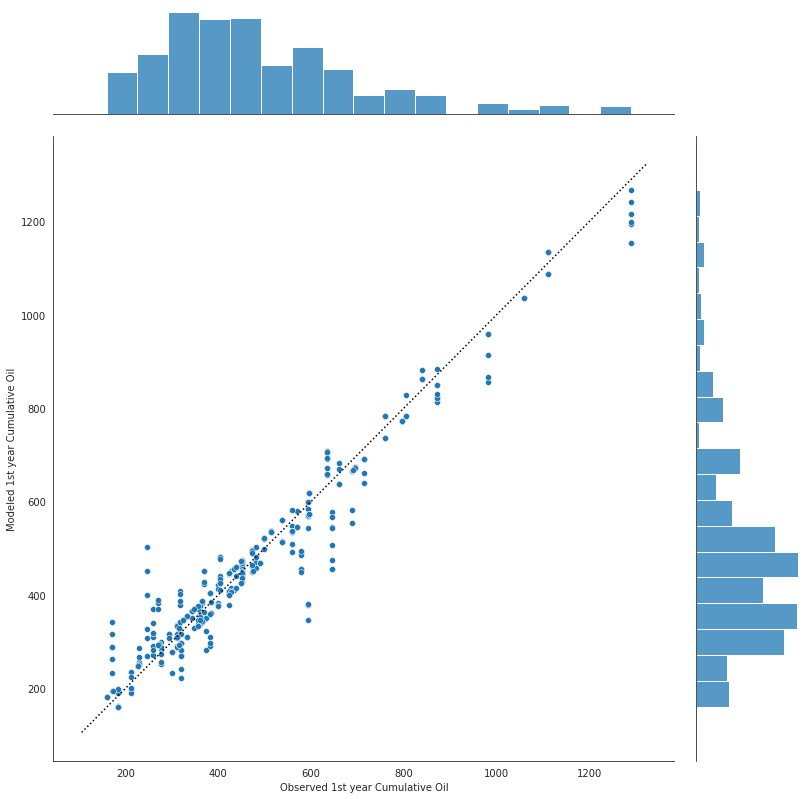

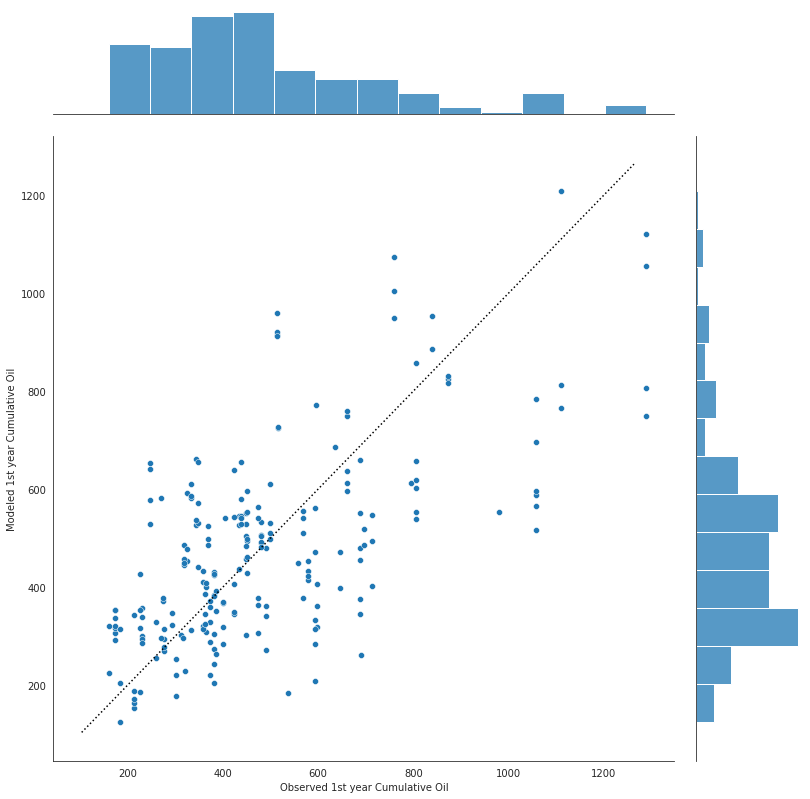

In [128]:
X_total = df_pca
y_total = df_merged['Cumoil1']
label = '1st year Cumulative Oil'

regressor_total1 = regress_svr(X_total, y_total, label)

In [ ]:
X_wcut = df_merged[[ "Porosity", "Perm", 'log_mindist', 'bottom to woc']]
y_wcut = df_merged['wcut1']
label = '1st year Cumulative Water'
regressor_wcut = regress_rf(X_wcut, y_wcut, label)

In [ ]:
X_wcut = df_merged[[  'bottom to woc']]
y_wcut = df_merged['wcut2']
label = '1st year Cumulative Water'
regressor_wcut = regress_linear(X_wcut, y_wcut, label)

In [ ]:
X_wcut = df_merged[[  'bottom to woc 1']]
y_wcut = df_merged['wcutincrease1']
label = '1st year Cumulative Water'
regressor_wcut = regress_linear(X_wcut, y_wcut, label)

In [ ]:
X_wcut = df_merged[['bottom to woc']]
y_wcut = df_merged['wcut1']
label = '1st year Cumulative Water'
regressor_wcut = regress_linear(X_wcut, y_wcut, label)

In [ ]:
X_wcut = np.concatenate([df_merged[['bottom to woc']].values, df_merged[['bottom to woc 1']].values, df_merged[['bottom to woc 2']].values], axis=0)
y_wcut = np.concatenate([df_merged['wcut1'].values, df_merged['wcut2'].values, df_merged['wcut3'].values], axis=0)
label = 'water cut'
regressor_wcut = regress_linear(X_wcut, y_wcut, label)

In [ ]:
X_wcut = np.concatenate([df_merged[['bottom to woc']].values, df_merged[['bottom to woc 1']].values, df_merged[['bottom to woc 2']].values], axis=0)
y_wcut = np.concatenate([df_merged['wcut1'].values, df_merged['wcut2'].values, df_merged['wcut3'].values], axis=0)
label = 'water cut'
regressor_wcut = regress_linear(X_wcut, y_wcut, label)
print(df_merged[['bottom to woc']].values - df_merged[['bottom to woc 1s']].values)

In [ ]:
X_wcut = np.concatenate([df_merged[['bottom to woc', 'woc rise 0']].values, df_merged[['bottom to woc', 'woc rise 1']].values, df_merged[['bottom to woc', 'woc rise 2']].values], axis=0)
y_wcut = np.concatenate([df_merged['wcut1'].values, df_merged['wcut2'].values, df_merged['wcut3'].values], axis=0)
label = 'water cut'
regressor_wcut = regress_linear(X_wcut, y_wcut, label)
print(df_merged[['bottom to woc']].values - df_merged[['bottom to woc 1s']].values)

In [ ]:
X_wcut = np.concatenate([df_merged[['bottom to woc']].values, df_merged[['bottom to woc']].values, df_merged[['bottom to woc']].values], axis=0)
y_wcut = np.concatenate([df_merged['wcut1'].values, df_merged['wcut2'].values, df_merged['wcut3'].values], axis=0)
label = 'water cut'
regressor_wcut = regress_linear(X_wcut, y_wcut, label)
print(df_merged[['bottom to woc']].values - df_merged[['bottom to woc 1s']].values)

In [ ]:
def calculate_cum1(X_total, X_wcut, total, wcut, oil, label):
    oil_tests = []
    oil_predict_tests = []
    np.random.seed(1)
    for i in range(10):
        X_total_train, X_total_test, X_wcut_train, X_wcut_test, total_train, total_test, wcut_train, wcut_test, oil_train, oil_test  = \
        train_test_split(X_total, X_wcut, total, wcut, oil , test_size = 0.3)
        regressor_total = RandomForestRegressor(n_estimators=800, max_depth=25, min_samples_leaf=2,\
                                   min_samples_split= 2, max_features= 'sqrt', bootstrap =False )

        regressor_total.fit(X_total_train, total_train)
        total_predict_test = regressor_total.predict(X_total_test)
        del regressor_total
        regressor_wcut = RandomForestRegressor(n_estimators=800, max_depth=25, min_samples_leaf=2,\
                                   min_samples_split= 2, max_features= 'sqrt', bootstrap =False )
        regressor_wcut.fit(X_wcut_train, wcut_train)     
        wcut_predict_test = regressor_wcut.predict(X_wcut_test)
        del regressor_wcut
        oil_predict_test = total_predict_test*(1-wcut_predict_test)
        oil_tests.append(oil_test)
        oil_predict_tests.append(oil_predict_test)
#         print(oil_test.shape == oil_predict_test.shape)
    
    oil_tests = np.array(oil_tests).flatten()
    oil_predict_tests = np.array(oil_predict_tests).flatten()
    print(oil_tests.shape)
    print(oil_predict_tests.shape)

    print("\nMETRICS FOR TESTING DATA:\n")
    print('Mean Absolute Error:', metrics.mean_absolute_error(oil_tests, oil_predict_tests))
    print('Mean Squared Error:', metrics.mean_squared_error(oil_tests, oil_predict_tests))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(oil_tests, oil_predict_tests)))
    print('R-Squared:', metrics.r2_score(oil_tests, oil_predict_tests))
    print('Explained variance:', metrics.explained_variance_score(oil_tests, oil_predict_tests))

    

    # Testing data plot
    with sns.axes_style('white'):
        g = (sns.jointplot(x=oil_tests, y=oil_predict_tests, kind='scatter', height=11).set_axis_labels
             ("Observed {}".format(label), "Modeled {}".format(label)))

    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, ':k')
    plt.savefig(
        "Regression_rf_testing.png",
        bbox_inches='tight', dpi=200)
    plt.show()
    plt.close()
    

In [ ]:
y_oil = df_merged['Cumoil1']
label = '1st year cumulative oil'
calculate_cum1(X_total, X_wcut, y_total, y_wcut, y_oil, label)

In [ ]:
X_total = df_merged[[ "Porosity", "Perm",  'sand prp.', 'bottom to woc', 'Comp_vel', 'wcut1']]
y_total = df_merged['Cumoil3']
label = '3rd year Cumulative Oil'

regressor_total1 = regress_rf(X_total, y_total, label)